# Analysis from Brian Goggin (uses newly-produced data as of September 2017)

In [80]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [81]:
#import dataset of project times from "data" folder
file = "../../../data/cleaned/all_quarters__one_record_per_project.csv"
df = pd.read_csv(file)

In [82]:
#First, filter out those projects that are exclusively non-residential (defined as those without units)
df = df[df['units'] > 0]

In [83]:
#Next, keep only those that reached completion at some point over the time period
df=df[pd.notnull(df['comp_date'])]

In [84]:
df.shape

(943, 24)

In [85]:
df=df[pd.notnull(df['firstfiled'])]

In [86]:
df.shape

(933, 24)

In [87]:
#drop duplicates for now, until manual cleaning is done
df= df[~ df.duplicated('dbi_permit', keep=False)]

In [88]:
df.shape

(872, 24)

In [89]:
#convert completion date to date variables type
df['project_duration_days'].describe()

count     872.000000
mean     1649.308486
std      1127.131210
min       157.000000
25%       786.000000
50%      1376.500000
75%      2250.000000
max      8807.000000
Name: project_duration_days, dtype: float64

In [90]:
df['project_time_years']=df['project_duration_days']/365

In [91]:
df['project_time_years'].describe()

count    872.000000
mean       4.518653
std        3.088031
min        0.430137
25%        2.153425
50%        3.771233
75%        6.164384
max       24.128767
Name: project_time_years, dtype: float64

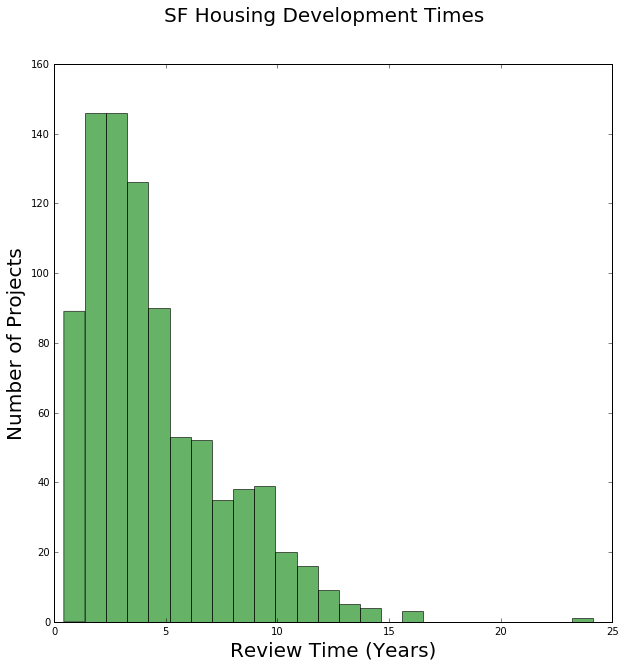

In [92]:
plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Projects', fontsize = 20)
ax = plt.hist(df['project_time_years'], bins=25, alpha=.6, color='g')
plt.savefig('../../../hitogram.png')
plt.show()

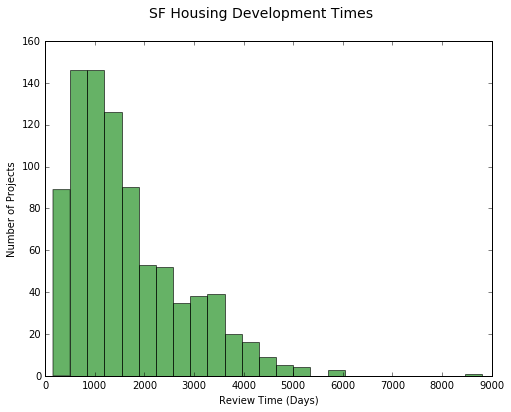

In [93]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('SF Housing Development Times', fontsize=14)
plt.xlabel('Review Time (Days)')
plt.ylabel('Number of Projects')
ax = plt.hist(df['project_duration_days'], bins=25, alpha=.6, color='g')
plt.show()

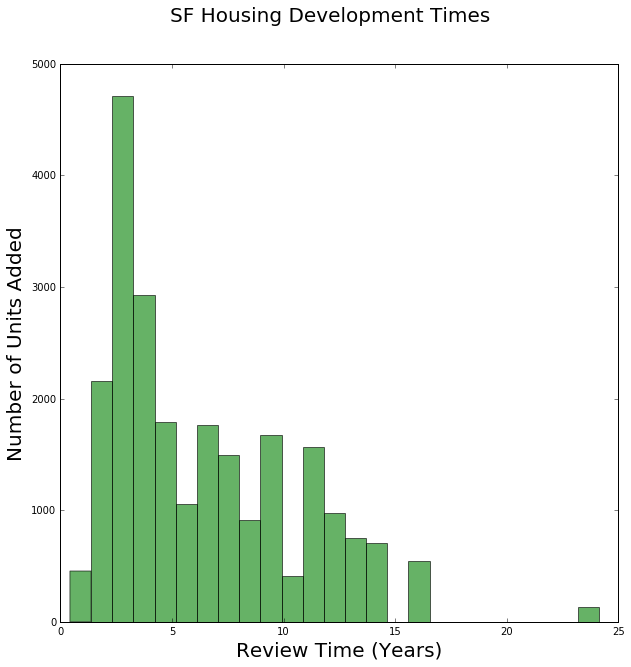

In [94]:
#Create dataset of net units added with 
list = []
uniqueid = 0
for index, row in df.iterrows():
    amount = int(row['units'])
    for units in range(0, amount):
        dictionary = {}
        dictionary['id']=uniqueid+1
        dictionary['time']=row['project_time_years']
        list.append(dictionary)
        uniqueid=uniqueid+1
df_units = pd.DataFrame(list)

plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Units Added', fontsize = 20)
ax = plt.hist(df_units['time'], bins=25, alpha=.6, color='g')
plt.savefig('../../../hitogram2.png')
plt.show()

In [95]:
df_units['time'].describe()

count    24028.000000
mean         6.418675
std          4.178464
min          0.430137
25%          2.816438
50%          5.024658
75%          9.624658
max         24.128767
Name: time, dtype: float64

In [96]:
df['units'].describe()

count    872.000000
mean      27.555046
std       80.132721
min        1.000000
25%        2.000000
50%        2.000000
75%        8.000000
max      754.000000
Name: units, dtype: float64

In [97]:
unit_cutoffs=[10, 50, 100, 200]
def unit_categories(value):
    if value['units'] <unit_cutoffs[0]:
        field = '0'+'-'+str(unit_cutoffs[0])
    elif (value['units'] >=unit_cutoffs[0]) & (value['units'] <unit_cutoffs[1]):
        field = str(unit_cutoffs[0])+'-'+str(unit_cutoffs[1])
    elif (value['units']>= unit_cutoffs[1]) & (value['units'] <unit_cutoffs[2]):
        field = str(unit_cutoffs[1])+'-'+str(unit_cutoffs[2])
    elif (value['units']>= unit_cutoffs[2]) & (value['units'] <200):
        field = str(unit_cutoffs[2])+'-'+str(unit_cutoffs[3])
    elif value['units']>=200:
        field = '>'+str(unit_cutoffs[3])
    return field
    
df['unitcat']=df.apply(unit_categories, axis=1)

In [98]:
df['unitcat'].value_counts()

0-10       666
10-50       91
50-100      48
100-200     38
>200        29
Name: unitcat, dtype: int64

In [99]:
cat_medians=[]
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median = df[df['unitcat']==cat]['project_duration_days'].median()
    cat_medians.append(median)

In [100]:
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

In [101]:
df['unitcat'].unique()

array(['0-10', '100-200', '10-50', '50-100', '>200'], dtype=object)

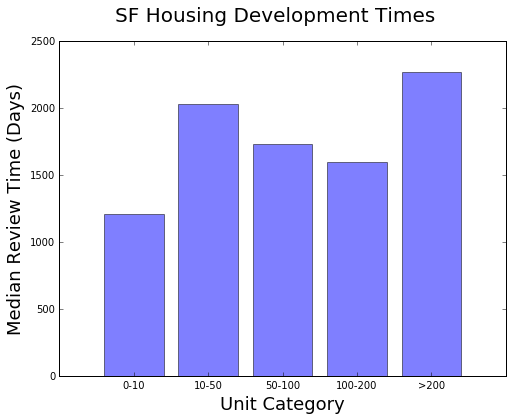

In [102]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.ylabel('Median Review Time (Days)', fontsize=18)
plt.xlabel('Unit Category', fontsize=18)
plt.bar(y_pos, cat_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.show()

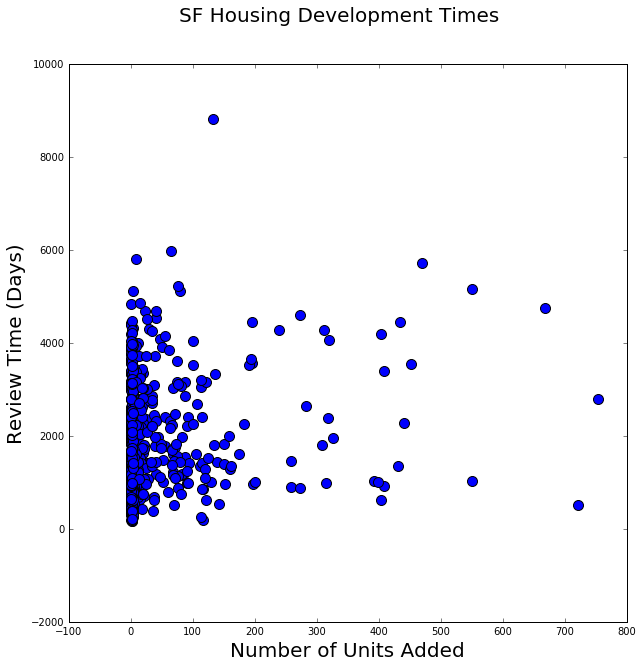

In [24]:
plt.figure(1, figsize=(10,10))
plt.scatter(df['units'], df['project_duration_days'], s=100)
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.ylabel('Review Time (Days)', fontsize = 20)
plt.xlabel('Number of Units Added', fontsize = 20)
plt.savefig('../../../scatter.png')

In [25]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years,unitcat
2356,18560,NaN,833-881 JAMESTOWN,4991277,2007-09-17,CONSTRUCTION,04/01/2015,2007-09-17,9924080S,1991-02-19,2007-09-17,1991-02-19,2007-09-17,CONSTRUCTION,"('2007-09-17', '2007-09-17', '2007-09-17', '20...",8807.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2015,Under Construction,132.0,14.0,-122.392222,37.717174,24.128767,100-200
843,26437,NaN,POTRERO1010 (BLDG 1 OF 2),3833001,2016-05-26,CONSTRUCTION,10/01/2016,2016-05-26,201112070227,2000-05-18,2016-05-26,2000-05-18,2016-05-26,CONSTRUCTION,"('2016-05-26', '2016-05-26')",5980.0,"('CONSTRUCTION', 'CONSTRUCTION')",3,2016,Under Construction,65.0,65.0,-122.396595,37.767108,16.383562,50-100
2748,17247,2008-11-07,1179 TENNESSEE ST,4172053,2014-12-18,CONSTRUCTION,01/01/2015,2014-03-21,9902819.0,1999-02-11,2008-11-07,1999-02-11,2014-12-18,CONSTRUCTION,"('2008-11-07', '2009-11-03', '2009-11-03', '20...",5803.0,"('BP REINSTATED', 'BP REINSTATED', 'BP REINSTA...",4,2014,Under Construction,8.0,8.0,-122.389058,37.755993,15.898630,0-10
2856,21263,2012-09-07,1000 16TH ST,3833001,2015-12-24,CONSTRUCTION,01/01/2016,2012-09-07,201112070227.0,2000-05-18,2012-07-13,2000-05-18,2015-12-24,CONSTRUCTION,"('2012-07-13', '2012-07-13', '2012-07-13', '20...",5706.0,"('PL APPROVED', 'PL APPROVED', 'PL APPROVED', ...",4,2015,Under Construction,470.0,470.0,-122.396595,37.767108,15.632877,>200
2073,24780,2014-02-12,480 POTRERO AV,3973002C,2016-01-13,CONSTRUCTION,07/01/2016,2015-03-26,201306250465,2002-03-22,2004-08-17,2002-03-22,2016-01-13,CONSTRUCTION,"('2004-08-17', '2012-10-04', '2012-10-04', '20...",5215.0,"('BP ISSUED', 'PL FILED', 'PL FILED', 'BP FILE...",2,2016,Under Construction,77.0,77.0,-122.407671,37.763478,14.287671,50-100


In [26]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = True)[0:20]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years,unitcat
2794,2346,NaN,850 30TH AV,1672024,2010-02-24,CONSTRUCTION,04/01/2010,2010-02-24,200910269851,2009-10-26,2009-10-26,2009-10-26,2010-02-24,CONSTRUCTION,"('2009-10-26', '2010-02-24')",157.0,"('BP FILED', 'CONSTRUCTION')",1,2010,Under Construction,2.0,NaN,-122.489282,37.773244,0.430137,0-10
2939,21046,NaN,414 SOMERSET ST,6044003,2015-10-05,CONSTRUCTION,10/01/2015,2015-10-05,201504103396.0,2015-04-10,2015-04-10,2015-04-10,2015-10-05,CONSTRUCTION,"('2015-04-10', '2015-10-05')",174.0,"('BP FILED', 'CONSTRUCTION')",3,2015,Under Construction,2.0,1.0,-122.407649,37.726252,0.476712,0-10
2272,10897,2012-10-26,55 05TH ST,3705039,2012-12-12,CONSTRUCTION,01/01/2013,2012-12-12,201206202986,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-12-12,CONSTRUCTION,"('2012-06-20', '2012-10-26', '2012-12-12')",195.0,"('BP FILED', 'BP APPROVED', 'CONSTRUCTION')",4,2012,Under Construction,116.0,8.0,-122.407185,37.783461,0.534247,100-200
3164,10900,2012-10-23,28 PRECITA AV,5518023,2012-11-15,CONSTRUCTION,01/01/2013,2012-11-15,201206203050,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-11-15,CONSTRUCTION,"('2012-06-20', '2012-10-23', '2012-11-15')",195.0,"('BP FILED', 'BP ISSUED', 'CONSTRUCTION')",4,2012,Under Construction,2.0,1.0,-122.418489,37.746472,0.534247,0-10
675,656,NaN,64 14TH ST,3529017,2009-08-07,CONSTRUCTION,10/01/2009,2009-08-07,200903194471,2009-03-19,2009-08-07,2009-03-19,2009-08-07,CONSTRUCTION,"('2009-08-07',)",196.0,"('CONSTRUCTION',)",3,2009,Under Construction,1.0,-1.0,-122.414942,37.768706,0.536986,0-10
2798,4588,NaN,290 FARALLONES ST,7105015,2011-01-11,CONSTRUCTION,01/01/2011,2011-01-11,201006033737,2010-06-03,2010-06-03,2010-06-03,2011-01-11,CONSTRUCTION,"('2010-06-03', '2010-06-03', '2011-01-11')",212.0,"('BP FILED', 'BP FILED', 'CONSTRUCTION')",4,2010,Under Construction,2.0,NaN,-122.462430,37.714286,0.580822,0-10
3416,29090,NaN,71 CURTIS ST,6464037,2017-03-02,CONSTRUCTION,04/01/2017,2017-03-02,201608266121,2016-08-26,2016-08-26,2016-08-26,2017-03-02,CONSTRUCTION,"('2016-08-26', '2016-08-26', '2017-03-02')",218.0,"('BP FILED', 'BP FILED', 'CONSTRUCTION')",1,2017,Under Construction,2.0,1.0,-122.439396,37.713630,0.597260,0-10
188,18801,NaN,352 WALLER ST,0859013,2015-03-06,CONSTRUCTION,04/01/2015,2015-03-06,201408214409.0,2014-08-21,2014-08-21,2014-08-21,2015-03-06,CONSTRUCTION,"('2014-08-21', '2015-03-06', '2015-03-06')",223.0,"('BP FILED', 'CONSTRUCTION', 'CONSTRUCTION')",1,2015,Under Construction,2.0,1.0,-122.429516,37.771555,0.610959,0-10
2048,13159,NaN,1022 RHODE ISLAND ST,4158002,2013-08-23,CONSTRUCTION,10/01/2013,2013-06-25,201301248731,2013-01-24,2013-01-24,2013-01-24,2013-08-23,CONSTRUCTION,"('2013-01-24', '2013-06-25', '2013-08-23')",250.0,"('BP FILED', 'CONSTRUCTION', 'CONSTRUCTION')",3,2013,Under Construction,2.0,1.0,-122.402115,37.756774,0.684932,0-10
1440,25849,NaN,3378 SACRAMENTO ST,1008047,2016-09-08,CONSTRUCTION,10/01/2016,2016-09-08,201602099198,2016-01-22,2016-02-09,2016-01-22,2016-09-08,CONSTRUCTION,"('2016-02-09', '2016-02-09', '2016-09-08')",253.0,"('BP FILED', 'BP FILED', 'CONSTRUCTION')",3,2016,Under Construction,4.0,0.0,-122.448412,37.788135,0.693151,0-10


# Breakdown by place. Possibly by average time per unit

In [43]:
#first, convert points to geodataframe
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.x, df.y)]
devs = GeoDataFrame(df, crs=crs, geometry=geometry)
devs = devs.to_crs({'init': 'epsg:4326'}) 

In [44]:
devs.shape

(872, 27)

In [45]:
#import neighborhoods
neighborhoods = gpd.read_file('../../../data/gis/41_neighborhoods/41_neighborhoods.shp')

In [46]:
#convert boundaries to geographic coordinate system to conform to points
neighborhoods = neighborhoods.to_crs({'init': 'epsg:4326'}) 

In [47]:
neighborhoods.shape

(41, 2)

In [49]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
df_nb = gpd.sjoin(devs, neighborhoods, how = 'inner', op='within')
df_nb.shape

(872, 29)

In [51]:
df_nb.tail()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years,unitcat,geometry,index_right,nhood
2547,11085,2008-12-09,1816 EDDY ST,1127007,2010-10-08,CONSTRUCTION,04/01/2013,2010-10-08,200806275595,2008-06-27,2008-12-09,2008-06-27,2010-10-08,CONSTRUCTION,"('2008-12-09', '2008-12-09', '2008-12-09', '20...",1739.0,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'BP IS...",1,2013,Under Construction,19.0,19.0,-122.437677,37.780881,4.764384,10-50,POINT (-122.437677 37.780881),40,Western Addition
2612,25403,2015-09-16,1594 GOLDEN GATE AV,0753010,2016-04-08,CONSTRUCTION,10/01/2016,2016-03-23,201502249184,2015-02-24,2015-02-24,2015-02-24,2016-04-08,CONSTRUCTION,"('2015-02-24', '2015-02-24', '2015-09-16', '20...",585.0,"('BP FILED', 'BP FILED', 'BP ISSUED', 'BP ISSU...",3,2016,Under Construction,3.0,1.0,-122.436768,37.779213,1.602740,0-10,POINT (-122.436768343 37.77921261199999),40,Western Addition
2760,25343,2013-12-19,1470 MCALLISTER ST,0776035,2016-06-15,CONSTRUCTION,10/01/2016,2015-05-22,201302150317,2013-02-15,2013-02-15,2013-02-15,2016-06-15,CONSTRUCTION,"('2013-02-15', '2013-02-15', '2013-02-15', '20...",1324.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP ISSUE...",3,2016,Under Construction,3.0,3.0,-122.436398,37.778276,3.627397,0-10,POINT (-122.436398168 37.7782758913),40,Western Addition
3087,10329,2007-08-21,701 GOLDEN GATE AV,0768013,2012-07-25,CONSTRUCTION,01/01/2013,2012-07-10,200610235755,2006-10-23,2007-08-21,2006-10-23,2012-07-25,CONSTRUCTION,"('2007-08-21', '2007-08-21', '2007-08-21', '20...",2262.0,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'BP IS...",4,2012,Under Construction,100.0,100.0,-122.422252,37.780686,6.197260,100-200,POINT (-122.422252 37.780686),40,Western Addition
3299,7881,2010-04-16,1345 TURK ST,0756001,2012-01-25,CONSTRUCTION,01/01/2012,2011-01-13,200911131168,2008-01-23,2008-12-09,2008-01-23,2012-01-25,CONSTRUCTION,"('2008-12-09', '2009-11-13', '2010-04-16', '20...",1439.0,"('BP ISSUED', 'BP FILED', 'BP ISSUED', 'BP ISS...",4,2011,Under Construction,32.0,32.0,-122.431217,37.780465,3.942466,10-50,POINT (-122.431217 37.780465),40,Western Addition


In [52]:
#create unit-year category so that we normalize by units when comparing geographies
df_nb['unityears']=df_nb['project_time_years']/df_nb['units']

In [53]:
cat_medians=[]
categories=df_nb['nhood'].unique().tolist()

In [54]:
categories = sorted(categories, key=lambda x: df_nb[df_nb['nhood']==x]['unityears'].median())

In [55]:
for cat in categories:
    median = df_nb[df_nb['nhood']==cat]['unityears'].median()
    cat_medians.append(median)

In [75]:
y_pos=np.arange(len(categories))
#y_pos = np.arange(0, 4*len(categories), 4)

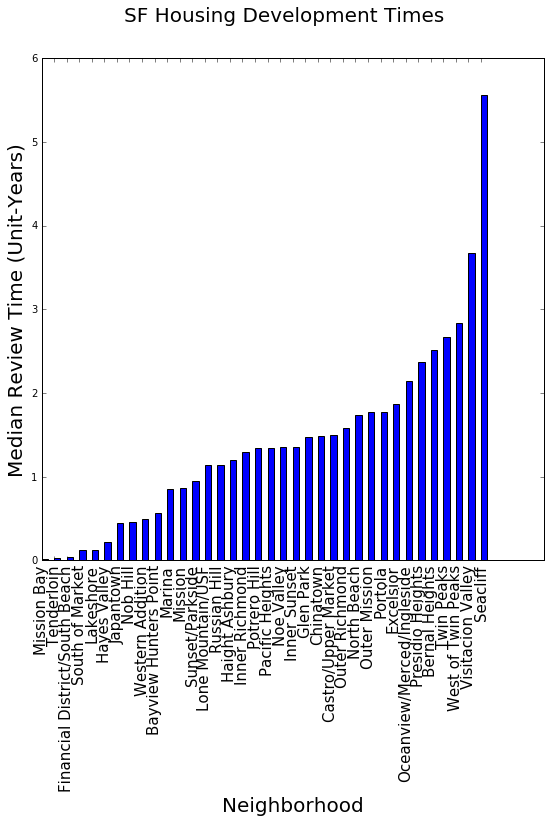

In [76]:
plt.figure(1, figsize=(9,9))
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.ylabel('Median Review Time (Unit-Years)', fontsize=20)
plt.xlabel('Neighborhood', fontsize=20)
plt.bar(y_pos, cat_medians, align='edge', alpha=1, width=0.5)
plt.xticks(y_pos, categories, rotation='vertical', fontsize=15)
plt.show()

In [ ]:
np.arange(len(categories)-len(categories), 2*len(categories), 2)

# Breakdown time by stage of process

In [103]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years,unitcat
10,25646,2014-11-05,238 MISSOURI ST,4003006,2016-04-26,CONSTRUCTION,10/01/2016,2015-07-09,201310038371,2013-10-03,2013-10-03,2013-10-03,2016-04-26,CONSTRUCTION,"('2013-10-03', '2013-10-03', '2013-10-03', '20...",1094.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2016,Under Construction,3.0,1.0,-122.396915,37.763366,2.997260,0-10
12,29286,NaN,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,8715004,2017-03-31,CONSTRUCTION,04/01/2017,2016-07-01,201408133775,2014-08-13,2016-07-01,2014-08-13,2017-03-31,CONSTRUCTION,"('2016-07-01', '2016-09-27', '2016-12-14', '20...",962.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2017,Under Construction,198.0,198.0,-122.390643,37.775051,2.635616,100-200
15,14501,NaN,1080 SUTTER ST,0279011,2014-01-14,CONSTRUCTION,04/01/2014,2013-04-24,200608290880,2006-10-25,2006-10-25,2006-10-25,2014-01-14,CONSTRUCTION,"('2006-10-25', '2009-05-28', '2009-05-28', '20...",2715.0,"('PL FILED', 'PL APPROVED', 'PL APPROVED', 'PL...",1,2014,Under Construction,35.0,35.0,-122.418041,37.788226,7.438356,10-50
16,26469,2015-06-26,101 LELAND AV,6250036,2016-01-21,CONSTRUCTION,10/01/2016,2016-01-21,200705221925,2007-05-22,2007-05-22,2007-05-22,2016-01-21,CONSTRUCTION,"('2007-05-22', '2007-05-22', '2007-05-22', '20...",3420.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2016,Under Construction,4.0,3.0,-122.405831,37.711766,9.369863,0-10
19,26913,NaN,188 BROAD ST,7107023,2013-07-01,CONSTRUCTION,01/01/2017,2013-03-12,201205039740,2012-05-03,2012-05-03,2012-05-03 00:00:00,2013-07-01,CONSTRUCTION,"('2012-05-03', '2012-05-03', '2012-05-03', '20...",1704.0,"('BP FILED', 'BP FILED', 'BP FILED', 'CONSTRUC...",4,2016,Under Construction,2.0,1.0,-122.458623,37.713424,4.668493,0-10


In [106]:
df = df[pd.notnull(df['BP_date'])]

In [107]:
df.shape

(600, 26)

In [108]:
df = df[pd.notnull(df['con_date'])]

In [109]:
df.shape

(600, 26)

In [ ]:
#also do graph by height-bulk restriction? 